In [11]:
import pandas as pd
from analysis_helpers import load_url_data, analyze_authors_comprehensive, add_domain_column

ALL_USERS = 'url_stream.csv'
LABELED_USERS = 'test_data.csv'

df = load_url_data(ALL_USERS)

def to_did(url):
    return url.split('/')[-1]

labeled = pd.read_csv(LABELED_USERS)
labeled['author'] = labeled['link'].apply(to_did)

df = add_domain_column(df)
author_stats = analyze_authors_comprehensive(df, labels_df=labeled)
test_data = author_stats[author_stats['label'].notnull()]

In [14]:
test_data.head()

,author,label,total_posts,unique_domains,unique_urls,first_post,last_post,top_domain,top_domain_count,domain_share,duration,duration_seconds,posts_per_minute,avg_time_between_posts,posts_to_bursty_urls
11234,did:plc:msian4dqa2rqalf3biilnf3m,good,285,1,237,2025-11-21 01:00:08+00:00,2025-11-22 04:01:07+00:00,europesays.com,285,1.0,1 days 03:00:59,97259.0,0.175819,342.461268,0
11622,did:plc:ni6cl7jipinqldoyowqlbrwp,good,152,1,152,2025-11-21 01:30:05+00:00,2025-11-23 22:20:31+00:00,newsbeep.com,152,1.0,2 days 20:50:26,247826.0,0.036800,1641.231788,0
11410,did:plc:n4o7ljxalqsknqv6ugfqujaw,bad,27,1,1,2025-11-21 00:56:34+00:00,2025-11-23 22:20:08+00:00,maps.google.c...,27,1.0,2 days 21:23:34,249814.0,0.006485,9608.230769,27
15487,did:plc:trdfsm22tzy5w4ue7l5pqfyt,good,18,1,18,2025-11-21 01:15:10+00:00,2025-11-21 02:30:55+00:00,bytesde.com,18,1.0,0 days 01:15:45,4545.0,0.237621,267.352941,0
9949,did:plc:kmobrdolqytsdby67y65yri2,bad,13,1,1,2025-11-21 01:00:08+00:00,2025-11-22 04:00:06+00:00,hitmusic80s.radioplayer.live,13,1.0,1 days 02:59:58,97198.0,0.008025,8099.833333,0


In [16]:
target_column = 'label'
feature_columns = ['unique_domains', 'unique_urls', 'avg_time_between_posts', 'posts_to_bursty_urls']

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare features and target
X = test_data[feature_columns]
y = test_data[target_column]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=2)
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

         bad       1.00      1.00      1.00         2
        good       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



Feature Importance Rankings:
unique_urls: 0.6197
avg_time_between_posts: 0.3803
unique_domains: 0.0000
posts_to_bursty_urls: 0.0000

Most dominant feature: unique_urls
Importance score: 0.6197


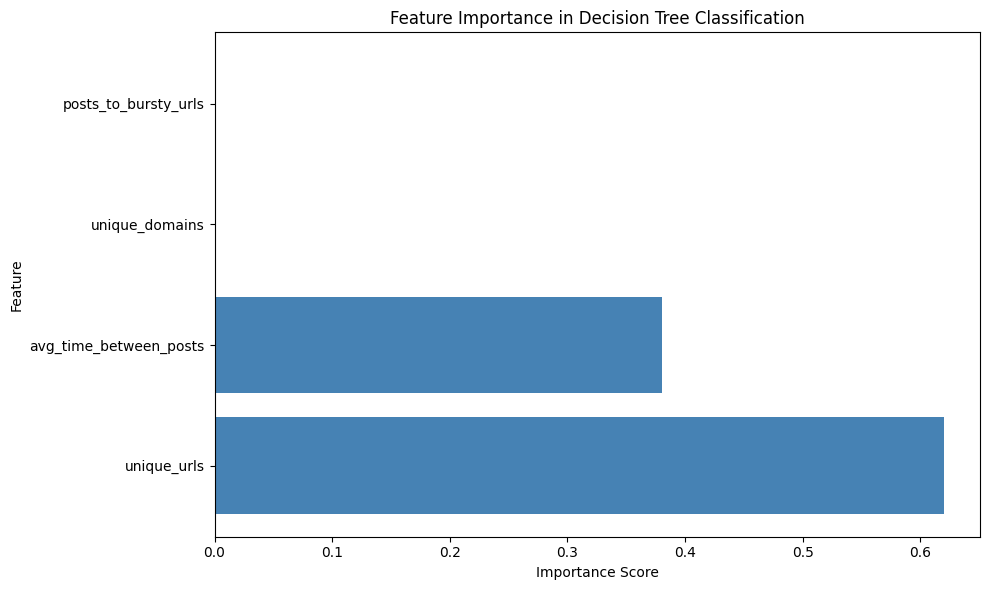

In [27]:
# Report feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': dt_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance Rankings:")
print("="*50)
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

print("\n" + "="*50)
print(f"Most dominant feature: {feature_importance.iloc[0]['feature']}")
print(f"Importance score: {feature_importance.iloc[0]['importance']:.4f}")

# Visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree Classification')
plt.tight_layout()
plt.show()